In [2]:
!pip install numpy torch pandas matplotlib umap-learn scikit-learn transformers datasets

In [3]:
!pip install datasets

In [4]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import gc

from datasets import load_dataset, DatasetDict
from transformers import (
    AutoModel,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score

In [7]:
from datasets import load_dataset

# Carregar o dataset CSV usando o caminho completo
health_dataset = load_dataset(
    "csv",  # Use "csv" em letras minúsculas
    data_files=r"G:\Mi unidad\Datasets\Industry_Sector.csv",  # Caminho completo do arquivo
    sep=","  # Delimitador do CSV
)

# Exibir o dataset
print(health_dataset)

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['file_name', 'text', 'class'],
        num_rows: 8817
    })
})


In [10]:
print(set(health_dataset["train"]["class"]))

{'financial', 'basic', 'capital', 'healthcare', 'technology', 'conglomerates', 'utilities', 'transportation', 'consumer', 'services', 'energy'}


In [12]:
!pip install ipywidgets

In [13]:
!pip install jupyterlab-widgets

In [14]:
from IPython.display import display
import ipywidgets as widgets

# Exemplo de widget simples
slider = widgets.IntSlider(value=5, min=0, max=10, step=1, description='Slider:')
display(slider)

IntSlider(value=5, description='Slider:', max=10)

In [15]:
print(set(health_dataset["train"]["class"]))

{'financial', 'basic', 'capital', 'healthcare', 'technology', 'conglomerates', 'utilities', 'transportation', 'consumer', 'services', 'energy'}


In [16]:
health_dataset = health_dataset.rename_column("class", "label")
health_dataset = health_dataset.class_encode_column("label")

Casting to class labels:   0%|          | 0/8817 [00:00<?, ? examples/s]

In [18]:
test_splitted_health_dataset = health_dataset["train"].train_test_split(
    test_size=0.3,
    stratify_by_column="label" # Preserva a distribuição dos dados de label
) # Irá resultar em um dataset contendo Treino e Teste

In [19]:
# A partir do conjunto de teste, vamos dividí-lo novamente em Teste e Validação
# A partir do original o dataset de teste possui 30% dos dados
# Para termos 20% e 10% vamos assumí-lo como o novo 100% e dividí-lo em 3 (66%/33%)
validation_splitted_health_dataset = test_splitted_health_dataset["test"].train_test_split(
    test_size=0.66,
    stratify_by_column="label"
)

In [20]:
splitted_health_dataset = DatasetDict({
    'train': test_splitted_health_dataset['train'], #
    'validation': validation_splitted_health_dataset['train'],
    'test': validation_splitted_health_dataset['test']
})

In [21]:
splitted_health_dataset

DatasetDict({
    train: Dataset({
        features: ['file_name', 'text', 'label'],
        num_rows: 6171
    })
    validation: Dataset({
        features: ['file_name', 'text', 'label'],
        num_rows: 899
    })
    test: Dataset({
        features: ['file_name', 'text', 'label'],
        num_rows: 1747
    })
})

In [22]:
splitted_health_dataset.set_format(type="pandas")
df = splitted_health_dataset["train"][:]
df.head()

,file_name,text,label
0,http:^^www.granitebank.com^kid.html,Granite Bank - For Kids Only! For ...,5
1,http:^^www.pwav.com^,Powerwave Technologies Home Page ...,8
2,http:^^www.caseys.com,Casey's General Store ...,7
3,http:^^www.uswest.com^media^index.html,U S WEST Media Group -1) || (agen...,7
4,http:^^www.aviall.com,"Allow: GET, HEAD URI: Welcome to Aviall ...",9


In [23]:
def health_label_int2str(row):
    return splitted_health_dataset["train"].features["label"].int2str(row)
df["label_name"] = df["label"].apply(health_label_int2str)
df.head()

,file_name,text,label,label_name
0,http:^^www.granitebank.com^kid.html,Granite Bank - For Kids Only! For ...,5,financial
1,http:^^www.pwav.com^,Powerwave Technologies Home Page ...,8,technology
2,http:^^www.caseys.com,Casey's General Store ...,7,services
3,http:^^www.uswest.com^media^index.html,U S WEST Media Group -1) || (agen...,7,services
4,http:^^www.aviall.com,"Allow: GET, HEAD URI: Welcome to Aviall ...",9,transportation


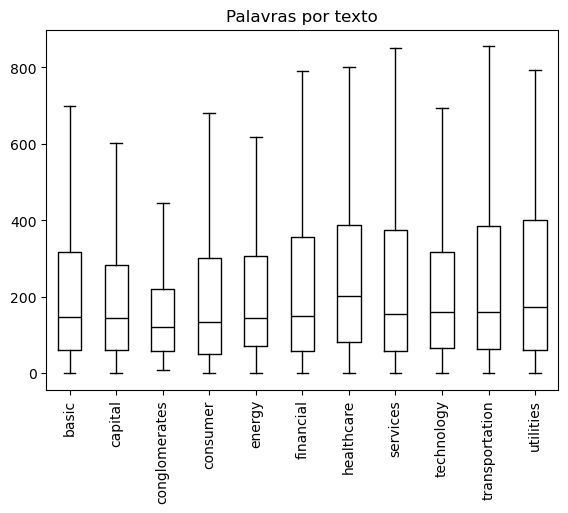

In [28]:
df["Palavras por texto"] = df["text"].str.split().apply(len)

df.boxplot(
    "Palavras por texto",
    by="label_name",
    grid=False,
    showfliers=False,
    color="black"
)
plt.suptitle("")
plt.xlabel("")
plt.xticks(rotation=90)
plt.show()

In [36]:
import os
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'  # Desabilitar aviso de symlinks

from transformers import AutoTokenizer

# Carregar o tokenizador do DistilBERT
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Exibir informações do tokenizador
print(tokenizer)

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


In [38]:
encoded_sample = tokenizer(df.iloc[0].text)
print(encoded_sample)
print(len(encoded_sample["input_ids"]))

{'input_ids': [101, 9753, 2924, 1011, 2005, 4268, 2069, 999, 2005, 4268, 2069, 999, 20643, 14715, 3619, 20643, 2015, 2173, 2005, 2035, 2017, 4268, 6373, 11021, 2015, 2188, 2006, 1996, 7479, 5456, 4268, 2188, 1064, 9753, 2924, 1064, 3361, 10250, 19879, 6591, 1064, 3945, 5906, 1064, 2739, 1010, 2998, 1010, 4633, 3604, 4219, 1064, 1056, 1012, 1058, 1012, 12468, 1010, 6023, 1064, 18699, 2451, 1064, 4268, 2069, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
67


In [40]:
def tokenize(batch):
  # Garantia que os dados de texto serão strings
  texts = [str(text) for text in batch["text"]]

  # Caso acima de 512, trunca-se os dados
  # Para o caso de saúde não teremos esse comportamento
  encodings = tokenizer(texts, padding=True, truncation=True)

  # Preserva a coluna label de saída no map
  encodings["label"] = batch["label"]

  return encodings

In [42]:
# Aplicar a função de tokenização ao dataset
health_text_encoded = splitted_health_dataset.map(
    tokenize,
    batched=True,  # Garante o processamento em batch
    batch_size=None  # Define um valor dinâmico ao batch
)

# Exibir o dataset tokenizado
print(health_text_encoded)

Map:   0%|          | 0/6171 [00:00<?, ? examples/s]

Map:   0%|          | 0/899 [00:00<?, ? examples/s]

Map:   0%|          | 0/1747 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6171
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 899
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1747
    })
})


In [43]:
health_text_encoded["train"].column_names

['label', 'input_ids', 'attention_mask']

In [44]:
health_text_encoded["train"][:5]

,label,input_ids,attention_mask
0,5,"[101, 9753, 2924, 1011, 2005, 4268, 2069, 999,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,8,"[101, 2373, 16535, 6786, 2188, 3931, 1996, 208...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,7,"[101, 9036, 1005, 1055, 2236, 3573, 1064, 2194...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,7,"[101, 1057, 1055, 2225, 2865, 2177, 1011, 1015...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,9,"[101, 3499, 1024, 2131, 1010, 2132, 24471, 207...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [48]:
import torch
from transformers import AutoModel

# Verificar se a GPU está disponível e definir o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar o modelo DistilBERT e movê-lo para o dispositivo (GPU ou CPU)
model = AutoModel.from_pretrained(model_ckpt).to(device)

# Exibir o dispositivo onde o modelo está carregado
print(f"Modelo carregado em: {device}")

Modelo carregado em: cpu


In [50]:
# Vamos utilizar GPU se tivermos
# Utilizando a API do HuggingFace repassamos o modelo distilbert para a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [52]:
def extract_hidden_states(batch):

    # Repassa entradas do modelo para a GPU
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad(): # Congela o modelo BERT, ou seja não calcula gradiente
        last_hidden_state = model(**inputs).last_hidden_state

    # Retornamos os valore da camada oculta para a CPU como um array Numpy
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
health_text_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "label"]
) # Transforma os tokens em Tensors utilizando PyTorch

# Mapeia os Tensors com Tokens para o modelo, resgatando os valores da camada oculta
health_hidden_features = health_text_encoded.map(
    extract_hidden_states,
    batched=True
)

In [ ]:
health_hidden_features["train"].column_names

In [ ]:
X_health_train = np.array(health_hidden_features["train"]["hidden_state"])
y_health_train = np.array(health_hidden_features["train"]["label"])

X_health_validation = np.array(health_hidden_features["validation"]["hidden_state"])
y_health_validation = np.array(health_hidden_features["validation"]["label"])

X_health_test = np.array(health_hidden_features["test"]["hidden_state"])
y_health_test = np.array(health_hidden_features["test"]["label"])

X_health_train.shape, X_health_validation.shape, X_health_test.shape

In [ ]:
X_health_scaled = MinMaxScaler().fit_transform(X_health_train)

mapper = UMAP(n_components=2, metric="cosine").fit(X_health_scaled)


df_embedding = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_embedding["label"] = y_health_train
df_embedding.head()

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(7,5))
axes = axes.flatten()

cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples"]
cmaps = cmaps + ["Greys", "Blues", "Oranges", "Reds", "Purples"]
cmaps = cmaps + ["Greens", "Blues", "Greens"]

health_labels = splitted_health_dataset["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(health_labels, cmaps)):
    df_embedding_sub = df_embedding.query(f"label == {i}")

    axes[i].hexbin(
        df_embedding_sub["X"],
        df_embedding_sub["Y"],
        cmap=cmap,
        gridsize=20,
        linewidths=(0,2)
    )
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

for ax in axes[13:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
lr_health_clf = LogisticRegression(max_iter=3000)
lr_health_clf.fit(X_health_train, y_health_train)
lr_health_clf.score(X_health_test, y_health_test)

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)

    plt.title("Matriz de confusão normalizada")
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
y_health_preds = lr_health_clf.predict(X_health_test)
plot_confusion_matrix(y_health_preds, y_health_test, health_labels)

In [ ]:
num_labels = len(health_labels)
health_model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [ ]:
batch_size = 32
num_train_epochs=5
learning_rate=2e-5

health_logging_steps = len(health_text_encoded["train"]) // batch_size

health_model_name = f"{model_ckpt}-finetuned-health-text-classification"
health_training_args = TrainingArguments(output_dir=health_model_name,
                                  num_train_epochs=num_train_epochs,
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=health_logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [ ]:
trainer = Trainer(model=health_model,
                  args=health_training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=health_text_encoded["train"],
                  eval_dataset=health_text_encoded["validation"], # Utilizar parcela de validação
                  tokenizer=tokenizer) # Utilizar o distilBERT inicialmente carregado

trainer.train()

In [ ]:
health_predictions_output = trainer.predict(health_text_encoded["test"])
health_predictions_output.metrics
health_predictions_output.predictions

In [ ]:
y_health_predictions = np.argmax(health_predictions_output.predictions, axis=1)
plot_confusion_matrix(y_health_predictions, y_health_test, health_labels)